In [1]:
using ForneyLab, LinearAlgebra, Flux.Optimise, Plots, Random
using Distributions: MvNormal, MixtureModel, pdf
using ForneyLab: unsafeMean, unsafeCov

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Warning: Package ForneyLab does not have DataStructures in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added DataStructures as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading DataStructures into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.
  ** incremental compilation may be fatally broken for this module **



ForneyLab is slow in algorithm generation when it comes to large factor graphs. One way to alleviate this issue is to render Bayesian inference in an online manner by updating the prior distribution successively with the posterior estimates, which is due to the recursive characteristic of Bayes formula. However, we can execute such a consecutive inference process only if exact inference is achievable for the given model specification. Variational Message Passing (VMP) by its nature is an iterative, approximate inference procedure, which requires messsages from the entire factor graph in order to update posterior beliefs and therefore not directly amenable to online inference paradigm.

Stochastic Variational Inference (SVI by Hoffman et al) is an efficient stochastic natural gradient descent method that scales variational inference in conditionally conjugate models to large datasets and allow online variational inference with streaming data. In ForneyLab, we designed an SVI node to render online variational inference possible. SVI node in ForneyLab acts like a plate notation in directed graphical models and allow the end-user to run inference over a smaller factor graph, which is computationally less expensive to build and speed up the algorithm generation by a factor of magnitude in certain cases, by updating the observations iteratively. Below we provide an example over a Gaussian Mixture Model.

# Synthetic Dataset 

In [2]:
Random.seed!(0);

In [3]:
# Synthetic Data
N = 150 # number of data points

p1 = MvNormal([-10.0, 2.5], [1 0.5;0.5 0.4])
p2 = MvNormal([-3.0, -4.5], [0.25 0; 0 0.5])
p3 = MvNormal([7.5, 1.5], [1 0.2; 0.2 1.25])

real_mix = MixtureModel(MvNormal[p1,p2,p3], [0.5, 0.2, 0.3])

dataset = rand(real_mix, N);

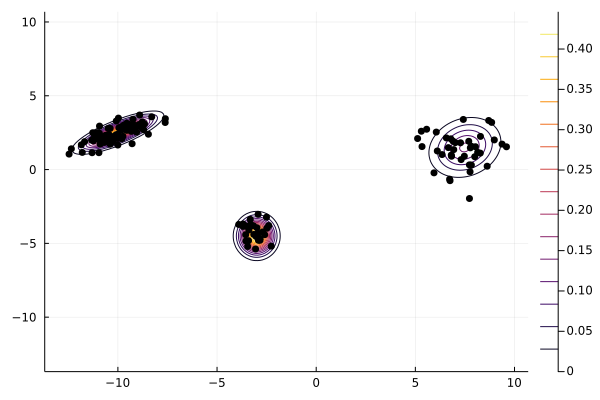

In [4]:
X = range(-13, 10, length=200)
Y = range(-13, 10, length=200)
Z1 = [pdf(p1, [x,y]) for y in Y, x in X]
Z2 = [pdf(p2, [x,y]) for y in Y, x in X]
Z3 = [pdf(p3, [x,y]) for y in Y, x in X]
contour(X, Y, Z1)
contour!(X, Y, Z2)
contour!(X, Y, Z3)


scatter!(dataset[1,:], dataset[2,:], legend=false, color=:black)

In [5]:
dataset_use = []
for n=1:N
    push!(dataset_use, dataset[:,n])
end

# Standard GMM with VMP

In [6]:
# -------------------------------------------
# ForneyLab Batch Model Specification
# -------------------------------------------
graph = FactorGraph()

@RV _pi ~ Dirichlet([1.,1.,1.])
@RV m_1 ~ GaussianMeanVariance(zeros(2), diagm(0=>ones(2)))
@RV W_1 ~ Wishart(diagm(0=>ones(2)),2)
@RV m_2 ~ GaussianMeanVariance(zeros(2), diagm(0=>ones(2)))
@RV W_2 ~ Wishart(diagm(0=>ones(2)),2)
@RV m_3 ~ GaussianMeanVariance(zeros(2), diagm(0=>ones(2)))
@RV W_3 ~ Wishart(diagm(0=>ones(2)),2)

z = Vector{Variable}(undef, N)
y = Vector{Variable}(undef, N)
for i = 1:N
    @RV z[i] ~ Categorical(_pi)
    @RV y[i] ~ GaussianMixture(z[i], m_1, W_1, m_2, W_2, m_3, W_3)
    
    placeholder(y[i], :y, index=i, dims=(2,))
end

In [7]:
# -------------------------------------------
# Approximate Distribution Factorization
# -------------------------------------------
pfz = PosteriorFactorization()

q_m1 = PosteriorFactor(m_1, id=:M1MF)
q_W1 = PosteriorFactor(W_1, id=:W1MF)
q_m2 = PosteriorFactor(m_2, id=:M2MF)
q_W2 = PosteriorFactor(W_2, id=:W2MF)
q_m3 = PosteriorFactor(m_3, id=:M3MF)
q_W3 = PosteriorFactor(W_3, id=:W3MF)
q_pi = PosteriorFactor(_pi, id=:PIMF)
q_z = Vector{PosteriorFactor}(undef, N)
for t=1:N
    q_z[t] = PosteriorFactor(z[t],id=:Z_*t)
end

In [8]:
run_time = 0.
# Build the algorithm
run_time += @elapsed algo = messagePassingAlgorithm(free_energy=true)

# Generate source code
run_time += @elapsed source_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(source_code))

freeEnergy (generic function with 1 method)

In [9]:
# -------------------------------------------
# Execute Inference
# -------------------------------------------
# Prepare posterior factors
marginals = Dict(:_pi => vague(Dirichlet,3),
                 :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[1.,-1.], v=100.0*diagm(0=>ones(2))),
                 :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[-1.,1.], v=100.0*diagm(0=>ones(2))),
                 :m_3 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(2), v=100.0*diagm(0=>ones(2))),
                 :W_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
                 :W_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
                 :W_3 => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2))

# Execute algorithm
n_its = 10
F_batch, time_batch = Float64[], Float64[]

data = Dict(:y => dataset_use)

for i = 1:n_its
    run_time += @elapsed for j=1:N
        step!(:Z_*j,data, marginals)
    end
    run_time += @elapsed stepPIMF!(data, marginals)
    run_time += @elapsed stepM1MF!(data, marginals)
    run_time += @elapsed stepW1MF!(data, marginals)
    run_time += @elapsed stepM2MF!(data, marginals)
    run_time += @elapsed stepW2MF!(data, marginals)
    run_time += @elapsed stepM3MF!(data, marginals)
    run_time += @elapsed stepW3MF!(data, marginals)
        
    # Store variational free energy
    run_time += @elapsed F = freeEnergy(data, marginals)
    push!(F_batch, F)
    push!(time_batch, run_time)
end

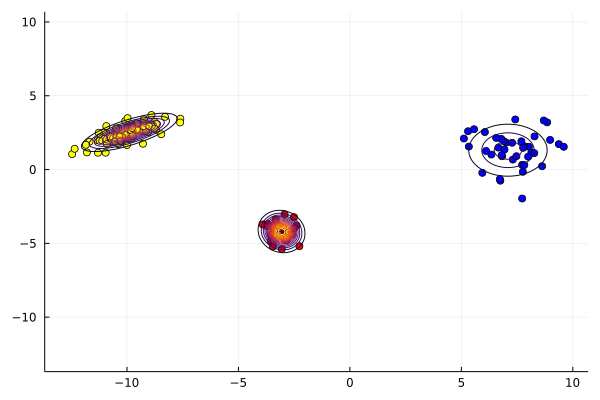

In [10]:
# -------------------------------------------
# Plot Estimations
# -------------------------------------------
color_list = [:blue, :yellow, :red]
scatter((dataset_use[1][1],dataset_use[1][2]),color=color_list[argmax(marginals[:z_1].params[:p])], legend=false)
for n=2:N
    scatter!((dataset_use[n][1],dataset_use[n][2]),color=color_list[argmax(marginals[:z_*n].params[:p])])
end
X = range(-13, 10, length=200)
Y = range(-13, 10, length=200)
Z1 = [pdf(MvNormal(unsafeMean(marginals[:m_1]),Matrix(Hermitian(inv(unsafeMean(marginals[:W_1]))))), [x,y]) for y in Y, x in X]
Z2 = [pdf(MvNormal(unsafeMean(marginals[:m_2]),Matrix(Hermitian(inv(unsafeMean(marginals[:W_2]))))), [x,y]) for y in Y, x in X]
Z3 = [pdf(MvNormal(unsafeMean(marginals[:m_3]),Matrix(Hermitian(inv(unsafeMean(marginals[:W_3]))))), [x,y]) for y in Y, x in X]
contour!(X, Y, Z1)
contour!(X, Y, Z2)
contour!(X, Y, Z3)

# GMM with SVI node

In [11]:
# -------------------------------------------
# ForneyLab MiniBatch Model Specification with SVI
# -------------------------------------------
graph = FactorGraph()

M = 50 # Minibatch size

# Specify the generative model
@RV _pi ~ Dirichlet([1.,1.,1.])
@RV _pi_ ~ Svi(_pi, opt=ForgetDelayDescent(1.,.6), q=vague(Dirichlet,3), batch_size=M, dataset_size=N)
@RV m_1 ~ GaussianMeanVariance(zeros(2), diagm(0=>ones(2)))
@RV m_1_ ~ Svi(m_1, opt=ForgetDelayDescent(1.,.6), 
               q=ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[1.,-1.], v=100.0*diagm(0=>ones(2))), 
               batch_size=M, dataset_size=N)
@RV W_1 ~ Wishart(diagm(0=>ones(2)),2)
@RV W_1_ ~ Svi(W_1, opt=ForgetDelayDescent(1.,.6),
               q=ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
               batch_size=M, dataset_size=N)
@RV m_2 ~ GaussianMeanVariance(zeros(2), diagm(0=>ones(2)))
@RV m_2_ ~ Svi(m_2, opt=ForgetDelayDescent(1.,.6), 
               q=ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[-1.,1.], v=100.0*diagm(0=>ones(2))), 
               batch_size=M, dataset_size=N)
@RV W_2 ~ Wishart(diagm(0=>ones(2)),2)
@RV W_2_ ~ Svi(W_2, opt=ForgetDelayDescent(1.,.6),
               q=ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
               batch_size=M, dataset_size=N)
@RV m_3 ~ GaussianMeanVariance(zeros(2), diagm(0=>ones(2)))
@RV m_3_ ~ Svi(m_3, opt=ForgetDelayDescent(1.,.6), 
               q=ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[0.,0.], v=100.0*diagm(0=>ones(2))), 
               batch_size=M, dataset_size=N)
@RV W_3 ~ Wishart(diagm(0=>ones(2)),2)
@RV W_3_ ~ Svi(W_3, opt=ForgetDelayDescent(1.,.6),
               q=ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
               batch_size=M, dataset_size=N)

z = Vector{Variable}(undef, M)
y = Vector{Variable}(undef, M)
for i = 1:M
    @RV z[i] ~ Categorical(_pi_)
    @RV y[i] ~ GaussianMixture(z[i], m_1_, W_1_, m_2_, W_2_, m_3_, W_3_)
    
    placeholder(y[i], :y, index=i, dims=(2,))
end

In [12]:
# -------------------------------------------
# Approximate Distribution Factorization
# -------------------------------------------
pfz = PosteriorFactorization()

q_m1 = PosteriorFactor(m_1, id=:M1MF)
q_W1 = PosteriorFactor(W_1, id=:W1MF)
q_m2 = PosteriorFactor(m_2, id=:M2MF)
q_W2 = PosteriorFactor(W_2, id=:W2MF)
q_m3 = PosteriorFactor(m_3, id=:M3MF)
q_W3 = PosteriorFactor(W_3, id=:W3MF)
q_pi = PosteriorFactor(_pi, id=:PIMF)
q_z = Vector{PosteriorFactor}(undef, M)
for t=1:M
    q_z[t] = PosteriorFactor(z[t],id=:Z_*t)
end

In [13]:
run_time = 0.
# Build the algorithm
run_time += @elapsed algo = messagePassingAlgorithm(free_energy=true)

# Generate source code
run_time += @elapsed source_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(source_code))

freeEnergy (generic function with 1 method)

In [14]:
# Prepare posterior factors
marginals = Dict(:_pi => vague(Dirichlet,3),
                 :_pi_ => vague(Dirichlet,3),
                 :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[1.,-1.], v=100.0*diagm(0=>ones(2))),
                 :m_1_ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[1.,-1.], v=100.0*diagm(0=>ones(2))),
                 :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[-1.,1.], v=100.0*diagm(0=>ones(2))),
                 :m_2_ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[-1.,1.], v=100.0*diagm(0=>ones(2))),
                 :m_3 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(2), v=100.0*diagm(0=>ones(2))),
                 :m_3_ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(2), v=100.0*diagm(0=>ones(2))),
                 :W_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
                 :W_1_ => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
                 :W_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
                 :W_2_ => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
                 :W_3 => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2),
                 :W_3_ => ProbabilityDistribution(MatrixVariate, Wishart, v=diagm(0=>100*ones(2)), nu=2))

marginals_mf = Dict() # to store all the random variables
;

In [15]:
# -------------------------------------------
# Execute Inference
# -------------------------------------------
n_its = 100
F_svi, time_svi = Float64[], Float64[]

for k = 1:n_its
    for i = 1:Int(N/M)
        data_use = dataset_use[M*(i-1)+1:i*M]
        data = Dict(:y => data_use)
        run_time += @elapsed for j=1:M
            step!(:Z_*j,data, marginals)
        end
        run_time += @elapsed stepPIMF!(data, marginals)
        run_time += @elapsed stepM1MF!(data, marginals)
        run_time += @elapsed stepW1MF!(data, marginals)
        run_time += @elapsed stepM2MF!(data, marginals)
        run_time += @elapsed stepW2MF!(data, marginals)
        run_time += @elapsed stepM3MF!(data, marginals)
        run_time += @elapsed stepW3MF!(data, marginals)
        
        # keep track local variables properly
        run_time += @elapsed for j=M*(i-1)+1:i*M
            l = j-(i-1)*M
            marginals_mf[:z_*j] = marginals[:z_*l]
        end

        # Store variational free energy
        run_time += @elapsed FE = freeEnergy(data, marginals)
        AE_compensate = 0
        Ent_compensate = 0
        run_time += @elapsed for j=1:M
            obs = ProbabilityDistribution(Multivariate, PointMass, m=data_use[j])
            AE_compensate += averageEnergy(GaussianMixture,obs,marginals[:z_*j],marginals[:m_1],marginals[:W_1],marginals[:m_2],marginals[:W_2],marginals[:m_3],marginals[:W_3])
            AE_compensate += averageEnergy(Categorical,marginals[:z_*j],marginals[:_pi])
            Ent_compensate += differentialEntropy(marginals[:z_*j])
        end
        run_time += @elapsed FE += (Int(N/M)-1)*(AE_compensate-Ent_compensate)
        push!(F_svi, FE)
        push!(time_svi, run_time)
    end
end

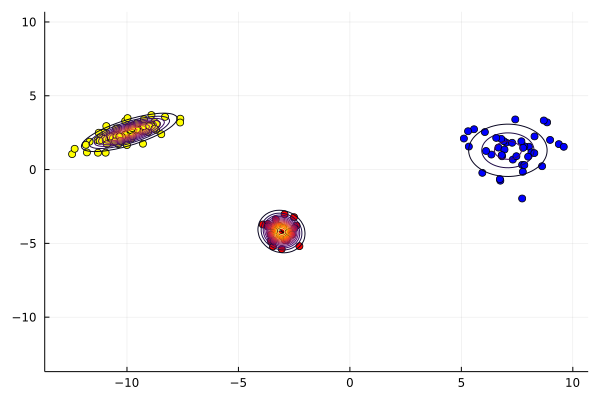

In [16]:
# -------------------------------------------
# Plot Estimations
# -------------------------------------------
color_list = [:blue, :yellow, :red]
scatter((dataset_use[1][1],dataset_use[1][2]),color=color_list[argmax(marginals_mf[:z_1].params[:p])], legend=false)
for n=2:N
    scatter!((dataset_use[n][1],dataset_use[n][2]),color=color_list[argmax(marginals_mf[:z_*n].params[:p])])
end
X = range(-13, 10, length=200)
Y = range(-13, 10, length=200)
Z1 = [pdf(MvNormal(unsafeMean(marginals[:m_1]),Matrix(Hermitian(inv(unsafeMean(marginals[:W_1]))))), [x,y]) for y in Y, x in X]
Z2 = [pdf(MvNormal(unsafeMean(marginals[:m_2]),Matrix(Hermitian(inv(unsafeMean(marginals[:W_2]))))), [x,y]) for y in Y, x in X]
Z3 = [pdf(MvNormal(unsafeMean(marginals[:m_3]),Matrix(Hermitian(inv(unsafeMean(marginals[:W_3]))))), [x,y]) for y in Y, x in X]
contour!(X, Y, Z1)
contour!(X, Y, Z2)
contour!(X, Y, Z3)

# Free Energies w.r.t. Run Time

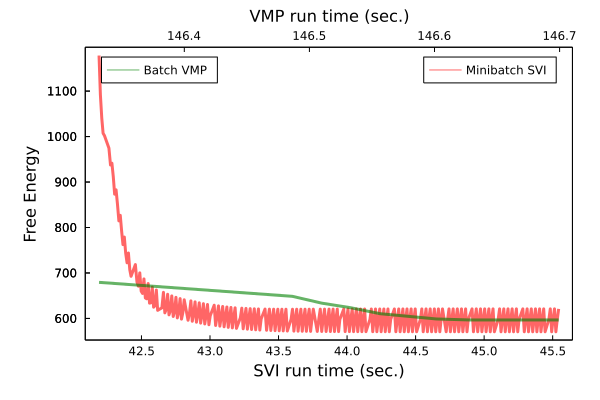

In [17]:
function twiny(sp::Plots.Subplot)
    sp[:top_margin] = max(sp[:top_margin], 30Plots.px)
    plot!(sp.plt, inset = (sp[:subplot_index], bbox(0,0,1,1)))
    twinsp = sp.plt.subplots[end]
    twinsp[:xaxis][:mirror] = true
    twinsp[:background_color_inside] = RGBA{Float64}(0,0,0,0)
    Plots.link_axes!(sp[:yaxis], twinsp[:yaxis])
    twinsp
end
twiny(plt::Plots.Plot = current()) = twiny(plt[1])

plot(time_svi[2:end], F_svi[2:end],lw=3,color=:red, alpha=0.6, label="Minibatch SVI", legend=:topright, box = :on, grid = :off, xlabel="SVI run time (sec.)", left_margin = 10Plots.mm, right_margin = 5Plots.mm, top_margin = 10Plots.mm, bottom_margin = 5Plots.mm)
p = twiny()
plot!(p,time_batch, F_batch,lw=3,color=:green, alpha=0.6, label="Batch VMP", legend=:topleft, box = :on, grid = :off, ylabel="Free Energy", xlabel="VMP run time (sec.)") 